**Regresión a partir de un dataset numérico**

In [176]:
# Importamos las librerias necesarias
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
import sklearn.datasets as skdata
import matplotlib.pyplot as plt

In [177]:
# Cargamos un dataset de prueba
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

X=dataset.drop("MPG", axis=1)
print("Son", X.shape[0], "conjuntos de datos")
print("Existen", X.shape[1], "descriptores")

# Separamos la muestra en test y training
X_train, X_test, y_train, y_test = train_test_split(dataset.drop("MPG", axis=1), dataset["MPG"], test_size=0.30, random_state=42)

train_stats = X_train.describe().transpose()
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
X_train_n = norm(X_train)
X_test_n = norm(X_test)

Son 392 conjuntos de datos
Existen 9 descriptores


In [178]:
# Creamos el modelo añadiendo cada capa 
input = tf.keras.Input(name='Input', shape=(X.shape[1],))
#n1 = layers.Normalization(name='Normalization', axis=1)(input)   #No es una buena idea, mejor normalizar antes los datos
h1 = layers.Dense(name='Dense1', units=64, activation='relu')(input)
h2 = layers.Dense(name='Dense2', units=64, activation='relu')(h1)
d1 = layers.Dropout(name='Dropout1', rate=0.3)(h2)
output = layers.Dense(name='Output', units=1, kernel_initializer='normal')(d1)

model=tf.keras.models.Model(inputs=input, outputs=output, name="Regressor")

# Compilamos empleando el accuracy para medir el funcionamiento del modelo
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001), loss='mse', metrics=['mae', 'mse'])

In [179]:
# Mostramos un resumen de nuestro modelo
model.summary()

Model: "Regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 9)]               0         
                                                                 
 Dense1 (Dense)              (None, 64)                640       
                                                                 
 Dense2 (Dense)              (None, 64)                4160      
                                                                 
 Dropout1 (Dropout)          (None, 64)                0         
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [186]:
# Creamos un callback para guardar el mejor modelo
best_model_callback = callbacks.ModelCheckpoint("best_models/best_model_regresor.h5",
                                                monitor='val_mse',
                                                save_best_only=True)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# Entrenamos el modelo
hist = model.fit(X_train_n, y_train,
                 #validation_data=(X_val, y_val), 
                 validation_split=0.2,
                 epochs=200,        # epoch: número de veces que verá todos los datos
                 #batch_size=100, # batch: número de datos que ve por pasada
                 callbacks=[best_model_callback, PrintDot()],
                 verbose=0)


....................................................................................................
....................................................................................................

In [181]:
# Evaluamos el modelo con el dataset de test
score = model.evaluate(X_test_n, y_test)
score

4/4 [==============================] - 0s 1ms/step - loss: 8.5062 - mae: 2.0857 - mse: 8.5062


[8.506152153015137, 2.0857279300689697, 8.506152153015137]

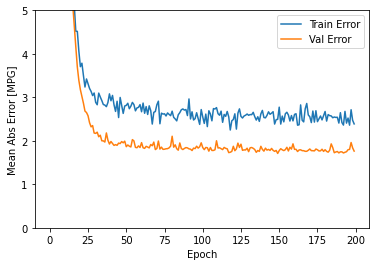

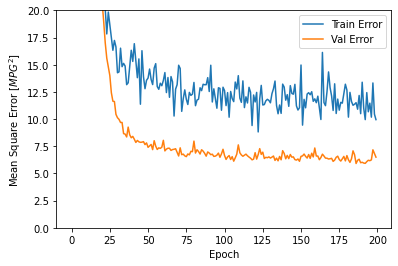

In [182]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(hist)

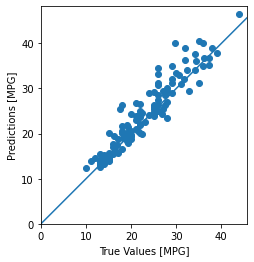

In [183]:
# Empleamos el modelo para predecir
preds_test = model.predict(X_test_n)

plt.scatter(y_test, preds_test)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])